In [ ]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import pandas as pd
import os
import time
import json
from PIL import Image

## Download and prepare the MS-COCO dataset


In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                        cache_subdir=os.path.abspath('.'),
                        origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                        extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                    cache_subdir=os.path.abspath('.'),
                    origin='http://images.cocodataset.org/zips/train2014.zip',
                    extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 327s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Optional: limit the size of the training set 


In [ ]:
with open('/content/annotations/captions_train2014.json', 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

# 取得所有圖片的image id

In [ ]:
image_ids = []
for i in annotations['annotations']:
  image_ids.append(i['image_id'])
image_ids = list(set(image_ids))
image_ids = sorted(image_ids)

In [ ]:
len(image_ids)

82783

# 取得每個圖片在coco dataset的category

In [ ]:
from pycocotools.coco import COCO
coco=COCO('/content/annotations/instances_train2014.json')

loading annotations into memory...
Done (t=10.28s)
creating index...
index created!


In [ ]:
cats = coco.loadCats(coco.getCatIds())
cat_dict = {}
i=0
for cat in cats:
  cat_dict[cat['id']] = cat['name']


In [ ]:
img_coco_catid = []
for imgid in image_ids:#image_ids lengths:82783
  temp = [] 
  imgIds = coco.getImgIds(imgIds = [imgid])
  img = coco.loadImgs(imgIds[0])[0]
  annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
  anns = coco.loadAnns(annIds)
  for i in anns:
    if i['category_id'] < 65: ###if i['category_id'] < 55: 篩50個category出來
      temp.append(i['category_id'])
  if len(temp) != 0: 
    temp = sorted(list(set(temp)))
  else:
    temp.append(0)
  img_coco_catid.append(temp)

In [ ]:
cat_temp = []
for i in img_coco_catid:
  for cat in i:
    if cat not in cat_temp:
      cat_temp.append(cat)
cat_temp = sorted(cat_temp)
len(cat_temp)

60

# onehot encoding

In [ ]:
img_coco_catname = []
for i in img_coco_catid:
  temp = []
  for id in i:
    if id != 0:
      temp.append(cat_dict[id])
    else:
      temp.append('none')
  img_coco_catname.append(temp)
img_coco_catname[:90]

[['bowl', 'orange', 'broccoli'],
 ['giraffe'],
 ['potted plant'],
 ['zebra'],
 ['person', 'umbrella'],
 ['person', 'horse', 'potted plant'],
 ['person', 'elephant'],
 ['car', 'truck', 'stop sign'],
 ['car', 'train', 'truck'],
 ['giraffe'],
 ['person', 'skateboard'],
 ['none'],
 ['airplane'],
 ['person', 'motorcycle', 'handbag'],
 ['knife'],
 ['fork', 'cake'],
 ['car', 'truck'],
 ['person', 'bench', 'dog'],
 ['person', 'cup', 'fork', 'knife', 'pizza', 'chair'],
 ['person', 'cup', 'knife', 'cake', 'chair'],
 ['person',
  'bench',
  'umbrella',
  'handbag',
  'cup',
  'knife',
  'spoon',
  'cake',
  'potted plant'],
 ['bowl', 'potted plant'],
 ['bottle', 'banana', 'sandwich'],
 ['giraffe'],
 ['person', 'car', 'kite'],
 ['person', 'train', 'stop sign'],
 ['zebra'],
 ['person', 'tie'],
 ['knife', 'pizza'],
 ['person', 'snowboard'],
 ['car', 'airplane'],
 ['none'],
 ['person', 'car', 'bus', 'suitcase'],
 ['elephant'],
 ['car', 'dog', 'frisbee'],
 ['person', 'umbrella', 'wine glass'],
 ['dog'

In [ ]:
cats = coco.loadCats(coco.getCatIds())
cat_dict_transfer = {0:'none'}
i=1
for cat in cats:
  cat_dict_transfer[i] = cat['name']
  i+=1
cat_dict_transfer
rev_cat_dict_transfer = {v: k for k, v in cat_dict_transfer.items()}

In [ ]:
#製作category和category_id的mapping (cat = 60版本)
cat_dict_transfer50 = {}
index = 0
for i in cat_dict_transfer.keys():
  if i < 60:
    cat_dict_transfer50[i] = cat_dict_transfer[i]
rev_cat_dict_transfer50 = {v: k for k, v in cat_dict_transfer50.items()}

In [ ]:
img_coco_catname[:5]

[['bowl', 'orange', 'broccoli'],
 ['giraffe'],
 ['potted plant'],
 ['zebra'],
 ['person', 'umbrella']]

In [ ]:
onehot_label = []
for cat_names in img_coco_catname:
  temparr = np.zeros(len(cat_dict_transfer50))#(category = 50)cat_dict_transfer50
  for cat_name in cat_names:
    cat_id = rev_cat_dict_transfer[cat_name]
    temparr[cat_id] = 1
  onehot_label.append(temparr)
len(onehot_label),len(onehot_label[0])

(82783, 60)

In [ ]:
image_paths = list(image_path_to_caption.keys())
image_paths = sorted(image_paths)

In [ ]:
#取新的(category = 50)onehot_label和image_paths的list
onehot_label_50 = []
image_paths_50 = []
index = 0
for i in onehot_label:
  if i[0] != 1:
    onehot_label_50.append(i)
    value = image_paths[index]
    image_paths_50.append(value)
  index+=1
len(onehot_label_50),len(onehot_label_50[0]),len(image_paths_50)

(76693, 60, 76693)

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

# Split train&test set

In [ ]:
def split_train_test(path_list,label_list):
  shuffle_buffer = 20
  path_ds = tf.data.Dataset.from_tensor_slices(path_list)
  label = tf.data.Dataset.from_tensor_slices(label_list)
  image = path_ds.map(load_image)
  ds = tf.data.Dataset.zip((image,label))
  ds = ds.shuffle(shuffle_buffer,reshuffle_each_iteration=False)
  return ds

In [ ]:
#做trainset和valset
train_ds = split_train_test(image_paths_50[:15000],onehot_label_50[:15000])
val_ds = split_train_test(image_paths_50[15000:17000],onehot_label_50[15000:17000])
# test_ds = split_train_test(image_paths_50[-1500:],onehot_label_50[-1500:])


In [ ]:
#做testset
test_path = tf.data.Dataset.from_tensor_slices(image_paths_50[-2000:])
test_image_tensor = test_path.map(load_image)
test_image_label = tf.data.Dataset.from_tensor_slices(onehot_label_50[-2000:])


In [ ]:
vgg19_finetune = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/vgg_multi_label60_ver3_25epoch_SGD.h5')

In [ ]:
test_image_tensor

<MapDataset shapes: (224, 224, 3), types: tf.float32>

In [ ]:
test_image_tensor_batch = test_image_tensor.batch(1)#batch_size先取1
vgg19_predict = vgg19_finetune.predict(test_image_tensor_batch)

In [ ]:
vgg19_predict.shape

(2000, 60)

In [ ]:
for i in range(10):           #印預測結果
  test_result = vgg19_predict[i].argsort()[-5:][::-1]   #取前五高的
  [print(cat_dict_transfer50[i]) for i in test_result]
  print("--------------------------------------------")

person
car
skis
bottle
airplane
--------------------------------------------
person
car
skis
bottle
airplane
--------------------------------------------
person
car
skis
airplane
bottle
--------------------------------------------
person
car
skis
bottle
airplane
--------------------------------------------
person
car
skis
airplane
bottle
--------------------------------------------
person
car
skis
bottle
airplane
--------------------------------------------
person
car
skis
airplane
bottle
--------------------------------------------
person
car
skis
bottle
airplane
--------------------------------------------
person
car
skis
airplane
bottle
--------------------------------------------
person
car
skis
bottle
airplane
--------------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


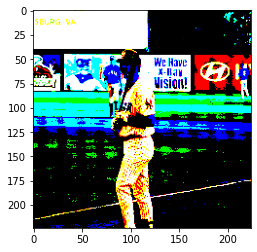

In [ ]:
import matplotlib.pyplot as plt
for i in test_image_tensor.take(1): #print正解圖片
  plt.imshow(i)

In [ ]:
# 取出Tensor圖片來看看
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
for index,(img,label) in enumerate(train_ds.take(6)):
    cat_label = []
    for ids in np.where(label == 1): 
      for id in ids:
        cat_label.append(cat_dict_transfer[id])
    #l = np.argmax(label.numpy())
    plt.subplot(2,3,index+1)
    plt.imshow(img)
    plt.title("Category Label: {} \n ".format(cat_label[:]))    #np.where(label == 1)
        
    plt.axis("off")

In [ ]:
len(train_ds)

In [ ]:
# 添加batch
batch_size = 64
train_ds = train_ds.batch(batch_size)   #16556/64 = 258.6875
val_ds = val_ds.batch(batch_size) #2648
# test_ds = test_ds.batch(batch_size)

In [ ]:
# 查看添加batch後的維度
trainiter = iter(train_ds)
x,y = trainiter.next()
print("training image batch shape : ",x.shape)
print("training label batch shape : ",y.shape)

training image batch shape :  (64, 224, 224, 3)
training label batch shape :  (64, 60)


# Build Model

In [ ]:
from tensorflow import keras
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,BatchNormalization,AveragePooling2D
from keras.optimizers import SGD
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.optimizers import RMSprop, Adam, SGD
from keras import Input

In [ ]:
res_model = VGG19(include_top=False,weights="imagenet", input_shape=(224,224,3))

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:

# mark loaded layers as not trainable

res_model.trainable = False
# allow last vgg block to be trainable

# add new classifier layers
model = Flatten()(res_model.output)
model = Dense(256, activation='relu')(model)
model = Dropout(0.5)(model)
model = BatchNormalization(name = 'Batch_normalize1')(model)
model = Dense(128, activation='relu', kernel_initializer='he_uniform')(model)
model = Dropout(0.5)(model)
model = BatchNormalization(name = 'Batch_normalize2')(model)
# model = Dense(64, activation='relu', kernel_initializer='he_uniform')(model)
# model = BatchNormalization(name = 'Batch_normalize3')(model)
output = Dense(60, activation='softmax')(model)

# define new model
model_transfer = Model(inputs=res_model.inputs, outputs=output)
model_transfer.summary()

# opt = Adam((learning_rate=1e-2))
# compile model
model_transfer.compile(loss='categorical_crossentropy', optimizer=SGD(lr=2e-4), metrics=["accuracy"])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model_transfer.fit(train_ds,epochs=35,validation_data=val_ds)


Epoch 1/35
235/235 [==============================] - 214s 628ms/step - loss: 12.0007 - accuracy: 0.0157 - val_loss: 10.2650 - val_accuracy: 0.0350
Epoch 2/35
235/235 [==============================] - 147s 624ms/step - loss: 11.6222 - accuracy: 0.0267 - val_loss: 9.9718 - val_accuracy: 0.0855
Epoch 3/35
235/235 [==============================] - 146s 621ms/step - loss: 11.3063 - accuracy: 0.0394 - val_loss: 9.7147 - val_accuracy: 0.1450
Epoch 4/35
235/235 [==============================] - 146s 619ms/step - loss: 11.0719 - accuracy: 0.0635 - val_loss: 9.4946 - val_accuracy: 0.2020
Epoch 5/35
235/235 [==============================] - 146s 623ms/step - loss: 10.8613 - accuracy: 0.0753 - val_loss: 9.3153 - val_accuracy: 0.2500
Epoch 6/35
235/235 [==============================] - 146s 620ms/step - loss: 10.6275 - accuracy: 0.0992 - val_loss: 9.1448 - val_accuracy: 0.2900
Epoch 7/35
235/235 [==============================] - 146s 620ms/step - loss: 10.4887 - accuracy: 0.1167 - val_loss: 

In [ ]:

res_model.trainable = False
# set layers trainable to True
for layer in res_model.layers[:-5]:
  layer.trainable = True


# add new classifier layers
model = Flatten()(res_model.output)
model = Dense(256, activation='relu')(model)
model = Dropout(0.5)(model)
model = BatchNormalization(name = 'Batch_normalize1')(model)
model = Dense(128, activation='relu', kernel_initializer='he_uniform')(model)
model = Dropout(0.5)(model)
model = BatchNormalization(name = 'Batch_normalize2')(model)
output = Dense(60, activation='softmax')(model)

# define new model
model_transfer2 = Model(inputs=res_model.inputs, outputs=output)
model_transfer2.summary()

# opt = Adam((learning_rate=1e-2))
# compile model
model_transfer2.compile(loss='categorical_crossentropy', optimizer=SGD(lr=2e-4), metrics=["accuracy"])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history2 = model_transfer2.fit(train_ds,epochs=40,validation_data=val_ds)

Epoch 1/40
235/235 [==============================] - 394s 2s/step - loss: 11.9568 - accuracy: 0.0228 - val_loss: 10.0594 - val_accuracy: 0.0885
Epoch 2/40
235/235 [==============================] - 384s 2s/step - loss: 11.5665 - accuracy: 0.0331 - val_loss: 9.7254 - val_accuracy: 0.1725
Epoch 3/40
235/235 [==============================] - 366s 2s/step - loss: 11.2624 - accuracy: 0.0518 - val_loss: 9.4565 - val_accuracy: 0.2555
Epoch 4/40
235/235 [==============================] - 364s 2s/step - loss: 10.9517 - accuracy: 0.0794 - val_loss: 9.2211 - val_accuracy: 0.3155
Epoch 5/40
235/235 [==============================] - 364s 2s/step - loss: 10.7036 - accuracy: 0.1085 - val_loss: 9.0283 - val_accuracy: 0.3710
Epoch 6/40
235/235 [==============================] - 367s 2s/step - loss: 10.4549 - accuracy: 0.1497 - val_loss: 8.8693 - val_accuracy: 0.4045
Epoch 7/40
235/235 [==============================] - 364s 2s/step - loss: 10.3102 - accuracy: 0.1769 - val_loss: 8.7299 - val_accuracy

In [ ]:
model_transfer2.save("/content/vgg_multi_label60_ver3_40epoch_.h5")

# model prediction

In [ ]:
vgg19_predict = model_transfer.predict(test_image_tensor_batch)

In [ ]:
# 取出Tensor圖片來看看
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
for label in test_image_label.take(6):
  # print(label)
  cat_label = []
  for ids in np.where(label == 1): 
    for id in ids:
      cat_label.append(cat_dict_transfer[id])
  print(cat_label)
  
  #l = np.argmax(label.numpy())
  # plt.subplot(2,3)
  # plt.imshow(img)
  # plt.title("Category Label: {} \n ".format(cat_label[:]))    #np.where(label == 1)
        
  # plt.axis("off")

['person', 'baseball bat', 'baseball glove']
['umbrella']
['sheep']
['person', 'horse']
['zebra']
['person', 'frisbee']


<Figure size 864x720 with 0 Axes>

In [ ]:
for i in range(10):           #印預測結果
  test_result = vgg19_predict[i].argsort()[-5:][::-1]   #取前五高的
  [print(cat_dict_transfer50[i]) for i in test_result]
  print("--------------------------------------------")

person
tennis racket
sports ball
baseball glove
chair
--------------------------------------------
person
umbrella
surfboard
stop sign
donut
--------------------------------------------
sheep
elephant
boat
horse
dog
--------------------------------------------
person
chair
tennis racket
umbrella
sports ball
--------------------------------------------
zebra
giraffe
tie
skateboard
apple
--------------------------------------------
person
sports ball
car
tennis racket
frisbee
--------------------------------------------
cat
giraffe
spoon
zebra
tie
--------------------------------------------
cat
sandwich
dog
stop sign
apple
--------------------------------------------
zebra
giraffe
banana
skateboard
fire hydrant
--------------------------------------------
person
snowboard
train
car
skis
--------------------------------------------


In [ ]:
model_transfer.save('/content/vgg_multi_label60_ver3_35epoch_SGD.h5')

In [ ]:
for layer in res_model.layers[:-5]:
  layer.trainable = True

opt = Adam(learning_rate=1e-4)
full_model = Sequential(layers=vgg19_finetune.layers)
full_model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate =2e-5),
    metrics=['accuracy'])


# full_model.summary()

In [ ]:
vgg19_finetune.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate =2e-5),
    metrics=['accuracy'])

vgg19_finetune.fit(train_ds,epochs=5,validation_data=val_ds)

Epoch 1/5
235/235 [==============================] - 178s 754ms/step - loss: 9.0989 - accuracy: 0.4959 - val_loss: 7.9250 - val_accuracy: 0.6060
Epoch 2/5
235/235 [==============================] - 167s 709ms/step - loss: 9.1142 - accuracy: 0.4999 - val_loss: 7.9315 - val_accuracy: 0.6085
Epoch 3/5
235/235 [==============================] - 147s 627ms/step - loss: 9.1244 - accuracy: 0.5113 - val_loss: 7.9460 - val_accuracy: 0.6110
Epoch 4/5
235/235 [==============================] - 146s 621ms/step - loss: 9.1532 - accuracy: 0.5127 - val_loss: 7.9668 - val_accuracy: 0.6180
Epoch 5/5
235/235 [==============================] - 145s 618ms/step - loss: 9.1303 - accuracy: 0.5171 - val_loss: 7.9813 - val_accuracy: 0.6195


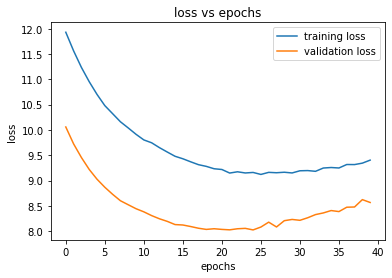

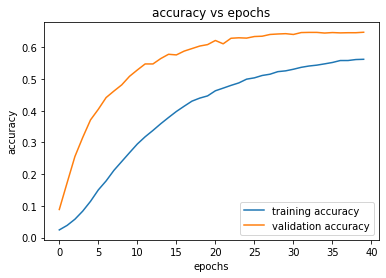

In [ ]:
import matplotlib.pyplot as plt
def plot_graph(history,string):
    
    plt.plot(history.history[string],label='training '+string)
    plt.plot(history.history['val_'+string],label='validation '+string)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.title(string+' vs epochs')
    plt.show()
plot_graph(history2,'loss')
plot_graph(history2,'accuracy')

In [ ]:
model_transfer.save('/content/vgg_multi_label60_ver2_30epoch_.h5')